# Ciencia de datos aplicada (ITBA): Tercer Entregable

**Predicción de nuevos datos utilizando el mejor modelo entrenado**

**Equipo:** Gaston Francois - Nicolas Suarez Durrels - Franco Rupnik

**Nombre del proyecto**: Prophetario

## Pipeline de procesamiento

In [1]:
#0. Importar librerías necesarias
import pandas as pd
import numpy as np
import re
import joblib
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from geopy.geocoders import OpenCage
from sklearn.neighbors import BallTree

In [2]:
# 1. Cargar datos
data = pd.read_csv('zonaprop_propiedades.csv')

In [3]:
# 2. Procesar tipo de vivienda
def obtener_clase(valor):
    if pd.isnull(valor):
        return None
    return valor.split('·')[0].strip()
data['vivienda'] = data['title'].apply(obtener_clase)


In [4]:
# 3. Procesar precio
ARS_TO_USD = 1 / 1200 # Tasa de conversión aproximada, ajustar según sea necesario
def convertir_precio(valor):
    if pd.isnull(valor):
        return None
    try:
        partes = valor.split()
        moneda = partes[0]
        numero_str = partes[1].replace('.', '').replace(',', '')
        numero = int(numero_str)
        if moneda == 'USD':
            return numero
        elif moneda == 'ARS':
            return int(numero * ARS_TO_USD)
        else:
            return None
    except:
        return None
data['price'] = data['rent_price'].apply(convertir_precio)


In [5]:
# 4. Procesar ubicación

#No es ideal que la apikey este pusheada en el repo, pero es una apikey de prueba y no tiene costo.
#api_key = "2da76b0a220c4d239c9c251fc20bab83"
api_key = "b508e874707d4e6d8c197569f77f3f80"
geolocator = OpenCage(api_key)

def geocodear(direccion):
    try:
        ubicacion = geolocator.geocode(direccion + ', Argentina')
        if ubicacion:
            print(f'{ubicacion.latitude}, {ubicacion.longitude}')
            return ubicacion.latitude, ubicacion.longitude
        else:
            return None, None
    except Exception as e:
        #print(f"Error geocodificando la dirección {direccion}: {e}")
        return None, None

data[['latitud', 'longitud']] = data['location'].apply(lambda x: pd.Series(geocodear(x)))
time.sleep(0.25)  # Esperar para evitar exceder el límite de solicitudes
data[['location', 'latitud', 'longitud']].head()

data_old = data.copy()

-34.4003895, -58.653931
-34.4925042, -58.5289983
-34.5900661, -58.4229274
-34.34905, -58.79308
-34.0, -64.0
-34.4842308, -58.4850135
-34.6127624, -58.3922796
-35.67502, -58.43456
-31.4135, -64.18105
-34.54969, -58.48572
-34.583527, -58.4294069
-34.50936, -58.519579
-34.54955, -58.46684
-34.42603, -58.57962
-32.94682, -60.63932
-31.61689, -61.93256
-34.5582702, -58.4601674
-31.389976, -64.2576766
-31.4135, -64.18105
-31.61689, -61.93256
-34.5857544, -58.4936798
-34.0, -64.0
-34.41427, -58.65171
-34.600734, -58.570615
-34.0, -64.0
-34.6418643, -58.668896
-34.0, -64.0
-34.5627, -58.45829
-34.58856, -58.43053
-38.0114306, -57.5554303
-34.6042823, -58.4469588
-31.4135, -64.18105
-34.5782395, -58.4255992
-32.94682, -60.63932
-31.38945, -64.17566
-31.4135, -64.18105
-34.0, -64.0
-34.62264, -58.44104
-34.60001, -58.44735
-34.5900661, -58.4229274
-31.4492883, -64.212081
-34.5656222, -58.4466359
-34.5565347, -58.4711526
-31.61689, -61.93256
-34.60064, -58.51231
-34.37079, -58.86977
-34.6614447, 

In [6]:
# 5. Procesar expensas
def convertir_expensas(valor):
    if pd.isnull(valor):
        return None
    if "No disponible" in valor:
        return None
    try:
        numero_str = valor.replace('Expensas $', '').strip().replace('.', '').replace(',', '')
        numero = int(numero_str)
        return numero
    except:
        return None
data['expenses'] = data['expenses_price'].apply(convertir_expensas)


In [7]:
# 6. Extraer variables numéricas
def extraer_numero_regex(valor):
    if pd.isnull(valor):
        return None
    try:
        match = re.search(r'(\d+(?:[.,]\d+)?)', valor)
        if match:
            numero_str = match.group(1).replace(',', '.')
            if '.' in numero_str:
                return float(numero_str)
            else:
                return int(numero_str)
        else:
            return None
    except:
        return None

columnas_mapeo = {
    'icon-stotal': 'm2_totales',
    'icon-scubierta': 'm2_cubiertos',
    'icon-ambiente': 'ambientes',
    'icon-bano': 'baños',
    'icon-cochera': 'cocheras',
    'icon-dormitorio': 'dormitorios'
}
for col_original, col_nueva in columnas_mapeo.items():
    data[col_nueva] = data[col_original].apply(extraer_numero_regex)


In [8]:
# 7. Procesar antigüedad
def convertir_antiguedad(valor):
    if pd.isnull(valor):
        return None
    if 'A estrenar' in valor:
        return 0
    try:
        match = re.search(r'\d+', valor)
        if match:
            return int(match.group(0))
        else:
            return None
    except:
        return None
data['antiguedad'] = data['icon-antiguedad'].apply(convertir_antiguedad)


In [9]:
# 8. Procesar features generales
data['general_features'] = data['general_features'].fillna('').astype(str)
def extract_plants(text):
    match = re.search(r'Cantidad plantas\s*:\s*(\d+|5 o más)', text)
    if match:
        if match.group(1) == '5 o más':
            return 5
        return int(match.group(1))
    return 1
def has_pool(text):
    return 'sí' if 'Pileta' in text else 'no'
def is_credit_compatible(text):
    return 'sí' if 'Apto profesional' in text else 'no'
data['Cantidad_plantas'] = data['general_features'].apply(extract_plants)
data['Pileta'] = data['general_features'].apply(has_pool)
data['Apto_credito'] = data['general_features'].apply(is_credit_compatible)


In [10]:
# 9. Seleccionar columnas relevantes
columns_to_keep = [
    'Cantidad_plantas', 'Pileta', 'Apto_credito', 'antiguedad', 'dormitorios',
    'cocheras', 'baños', 'ambientes', 'm2_totales', 'm2_cubiertos', 'expenses',
    'price', 'vivienda','latitud', 'longitud'
]
data = data[columns_to_keep]


In [11]:
# 10. Eliminar outliers extremos (3*IQR)
def get_extreme_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers
columns_numeric = ['price', 'm2_totales', 'm2_cubiertos', 'dormitorios', 'baños', 'antiguedad']
extreme_outliers = pd.DataFrame()
for column in columns_numeric:
    outliers = get_extreme_outliers(data, column)
    extreme_outliers = pd.concat([extreme_outliers, outliers])
extreme_outliers = extreme_outliers.drop_duplicates()
data = data.drop(index=extreme_outliers.index)


In [12]:
# 11. Eliminar duplicados
data = data.drop_duplicates()

In [13]:
# 12. Eliminar filas con "No disponible" en vivienda
data = data[~data["vivienda"].str.strip().str.lower().eq("no disponible")]

In [14]:
# 13 Calcular precio promedio por m2 de propiedades cercanas

# Primero, crear una copia de los datos sin valores nulos en lat/long para el cálculo
data_valid_coords = data.dropna(subset=['latitud', 'longitud']).copy()

# Convertir lat/long a radianes para el cálculo de distancia
data_valid_coords['lat_rad'] = np.radians(data_valid_coords['latitud'])
data_valid_coords['long_rad'] = np.radians(data_valid_coords['longitud'])

# Crear el árbol de búsqueda solo con coordenadas válidas
coords = np.column_stack([data_valid_coords['lat_rad'], data_valid_coords['long_rad']])
tree = BallTree(coords, metric='haversine')

# Calcular precio por m2 para cada propiedad
data_valid_coords['price_per_m2'] = data_valid_coords['price'] / data_valid_coords['m2_totales']

# Encontrar vecinos cercanos (dentro de 1km) y calcular precio promedio
RADIUS_KM = 1.0  # Radio de búsqueda en kilómetros
earth_radius = 6371  # Radio de la tierra en km

# Función para calcular el precio promedio de propiedades cercanas
def get_nearby_avg_price(idx):
    # Obtener coordenadas de la propiedad actual
    lat, lon = data_valid_coords.iloc[idx][['lat_rad', 'long_rad']]

    # Buscar propiedades dentro del radio
    indices = tree.query_radius([[lat, lon]], r=RADIUS_KM/earth_radius)[0]

    # Excluir la propiedad actual
    indices = indices[indices != idx]

    if len(indices) > 0:
        # Tomar hasta 10 propiedades más cercanas
        indices = indices[:10]
        # Calcular precio promedio por m2
        return data_valid_coords.iloc[indices]['price_per_m2'].mean()
    return None

# Aplicar la función a cada propiedad con coordenadas válidas
data_valid_coords['precio_m2_cercano'] = [get_nearby_avg_price(i) for i in range(len(data_valid_coords))]

# Crear la columna en el dataset original y asignar los valores calculados
data['precio_m2_cercano'] = np.nan
data.loc[data_valid_coords.index, 'precio_m2_cercano'] = data_valid_coords['precio_m2_cercano']

# Eliminar columnas temporales
data = data.drop(['lat_rad', 'long_rad', 'price_per_m2'], axis=1, errors='ignore')
reference_data = data.copy()

In [15]:
# 14. Imputar valores nulos
columnas_media_round = ['antiguedad', 'dormitorios', 'baños', 'ambientes']
columnas_media = ['m2_totales', 'm2_cubiertos','expenses', 'precio_m2_cercano']

mask_casas = data['vivienda'].str.contains('Casa', case=False, na=False)
data.loc[mask_casas, 'expenses'] = data.loc[mask_casas, 'expenses'].fillna(0)
for columna in columnas_media_round:
    data[columna] = data.groupby('vivienda')[columna].transform(lambda x: x.fillna(round(x.mean(), 0)))
for columna in columnas_media:
    data[columna] = data.groupby('vivienda')[columna].transform(lambda x: x.fillna(x.mean()))
data['cocheras'] = data['cocheras'].fillna(0)

#Hay que eliminar las filas con valores nulos en precio, latitud y longitud
data = data.dropna(subset=['price','latitud', 'longitud'])

In [16]:
# 15. Estandarizar variables numéricas, menos precio porque es la variable objetivo y es logarítmica
columnas_salida = ['Cantidad_plantas', 'antiguedad', 'dormitorios', 'cocheras', 'baños',
                   'ambientes', 'm2_totales', 'm2_cubiertos', 'expenses','latitud', 'longitud','precio_m2_cercano']
scaler = StandardScaler()
scaled_values = scaler.fit_transform(data[columnas_salida])
df_scaled = pd.DataFrame(scaled_values, columns=columnas_salida, index=data.index)
data[columnas_salida] = df_scaled

#Logaritmo en la variable objetivo 'price'
data['price'] = np.log1p(data['price'])

In [17]:
# 16. Codificar variables categóricas
columnas_categoricas = ["Pileta","Apto_credito","vivienda"]
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first")
encoded_data = onehot_encoder.fit_transform(data[columnas_categoricas])
feature_names = onehot_encoder.get_feature_names_out(columnas_categoricas)
encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=data.index)
data = data.drop(columns=columnas_categoricas)
data = pd.concat([data, encoded_df], axis=1)

In [18]:
# Miramos los datos finales
data

,Cantidad_plantas,antiguedad,dormitorios,cocheras,baños,ambientes,m2_totales,m2_cubiertos,expenses,price,latitud,longitud,precio_m2_cercano,Pileta_sí,Apto_credito_sí,vivienda_Departamento,vivienda_PH
0,-0.122586,-0.155294,1.292141,-0.043085,1.143656,0.785913,0.553808,1.989371,-0.721599,13.287880,-0.084433,0.174356,0.128995,0.0,0.0,0.0,0.0
2,-0.122586,1.039359,0.332080,-0.043085,-0.994046,0.140683,-0.779901,-0.723106,0.389640,11.931642,-0.100440,0.197861,0.785343,0.0,0.0,1.0,0.0
4,8.157540,-0.901952,0.332080,-0.043085,1.143656,0.140683,3.476936,0.947076,1.893081,12.847929,-0.075511,0.148176,-1.524186,1.0,0.0,0.0,0.0
5,-0.122586,-0.951730,2.252201,0.304875,5.419061,2.076372,1.265787,3.584206,-0.721599,13.038767,-0.014853,-0.831474,-0.429212,0.0,0.0,0.0,0.0
9,-0.122586,1.537131,0.332080,-0.043085,0.074805,0.140683,-0.448981,0.155938,0.912576,12.100718,0.434628,-0.865537,-1.128343,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,-0.122586,0.292701,0.332080,-0.391046,0.074805,0.785913,0.333194,0.231284,-0.721599,11.849405,-0.123207,0.164215,-0.797961,0.0,0.0,0.0,0.0
1168,-0.122586,0.541587,0.332080,0.304875,-0.994046,0.140683,0.483612,0.231284,-0.721599,11.775297,-0.014853,-0.831474,-0.584074,0.0,0.0,0.0,0.0
1169,-0.122586,0.043815,0.332080,0.304875,0.074805,0.785913,0.483612,-0.522182,-0.721599,11.849405,-0.014853,-0.831474,-0.584074,0.0,0.0,0.0,0.0
1170,-0.122586,-0.752621,0.332080,0.304875,-0.994046,-1.149777,0.232915,-0.522182,-0.721599,11.759793,-0.128821,0.173522,-0.377516,0.0,0.0,0.0,0.0


In [19]:
# 17. Guardar el dataset final y los objetos de transformación
data.to_csv("dataset_final.csv", index=False)
reference_data.to_csv("dataset_reference.csv", index=False)
joblib.dump(scaler, 'models/standardscaler.joblib')
joblib.dump(onehot_encoder, 'models/onehotencoder.joblib')
print("Preprocesamiento finalizado y archivos guardados.")

Preprocesamiento finalizado y archivos guardados.


## Entrenar el modelo con los datos preprocesados

In [21]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style="whitegrid")

In [22]:
# 1. Cargar el dataset preprocesado
df = pd.read_csv("dataset_final.csv")

df.head()

,Cantidad_plantas,antiguedad,dormitorios,cocheras,baños,ambientes,m2_totales,m2_cubiertos,expenses,price,latitud,longitud,precio_m2_cercano,Pileta_sí,Apto_credito_sí,vivienda_Departamento,vivienda_PH
0,-0.122336,-0.153561,1.287793,-0.042520,1.139720,0.785883,0.548045,1.987064,-0.720383,13.287880,-0.084484,0.175701,0.127703,0.0,0.0,0.0,0.0
1,-0.122336,1.041811,0.330927,-0.042520,-0.993859,0.140923,-0.777725,-0.722050,0.392334,11.931642,-0.100523,0.199241,0.775435,0.0,0.0,1.0,0.0
2,8.174239,-0.900669,0.330927,-0.042520,1.139720,0.140923,3.453773,0.946062,1.897776,12.847929,-0.075545,0.149481,-1.526312,1.0,0.0,0.0,0.0
3,-0.122336,-0.950476,2.244660,0.306049,5.406877,2.075802,1.255786,3.579922,-0.720383,13.038767,-0.014768,-0.831630,-0.452466,0.0,0.0,0.0,0.0
4,-0.122336,1.539883,0.330927,-0.042520,0.072931,0.140923,-0.448775,0.155904,0.915966,12.100718,0.435594,-0.865744,-1.130269,0.0,0.0,1.0,0.0


In [23]:
# 2. Separar las características y la variable objetivo
X = df.drop(columns=["price"])
y = df["price"]

In [24]:
# 3. Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# 4. Definir los parámetros del modelo LightGBM
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.15,
    max_depth=-1,
    n_estimators=100,
    num_leaves=11,
    random_state=100,
    verbose=-1
)

In [26]:
# 5. Entrenar el modelo
lgb_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.15, num_leaves=11, random_state=100, verbose=-1)

In [27]:
# 6. Hacer predicciones en el conjunto de prueba
y_pred = lgb_model.predict(X_test)

In [28]:
# 7. Transformar las predicciones de logaritmo a escala original
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

In [29]:
# 8. Evaluar el modelo
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 39047.10
MSE: 3156020017.02
RMSE: 56178.47
R2: 0.68


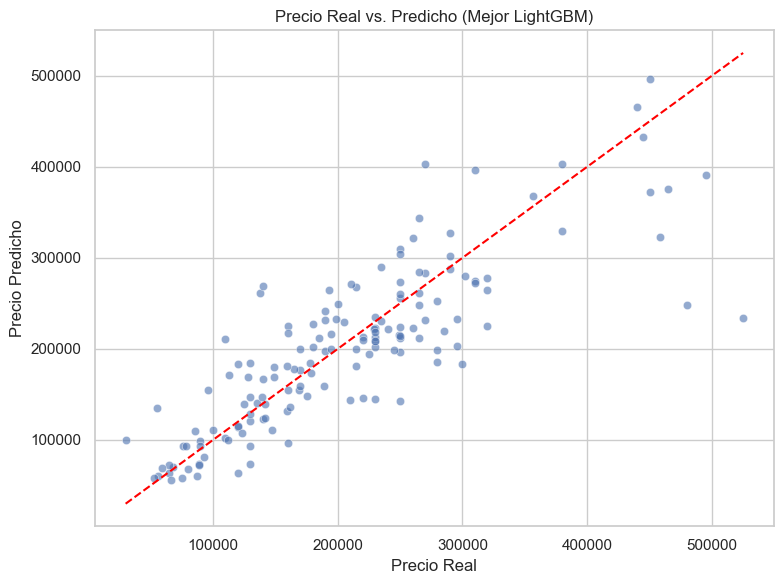

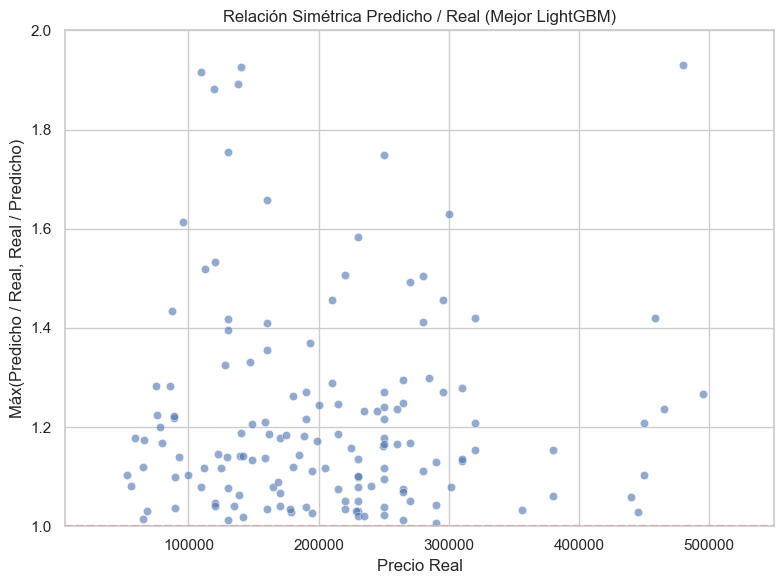

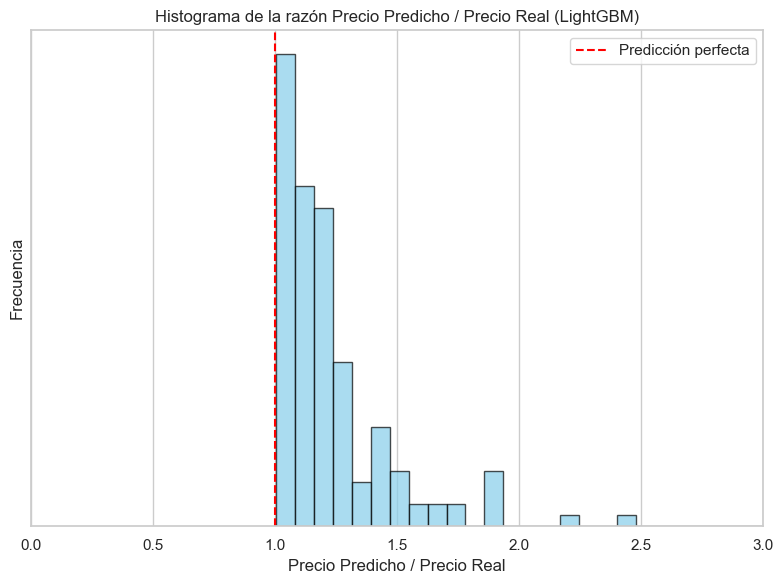

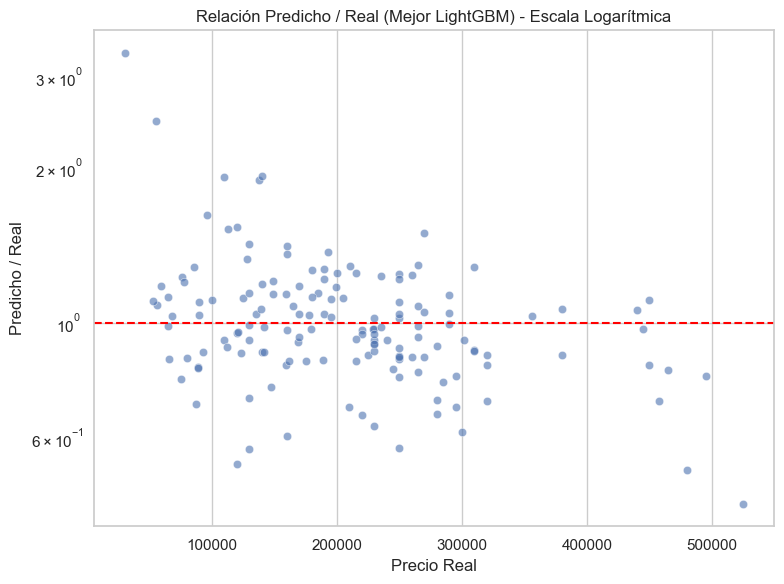

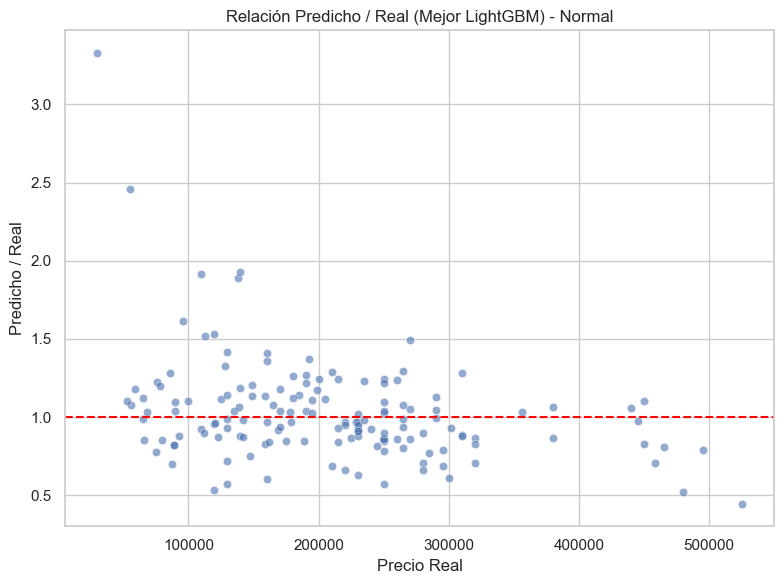

In [30]:
# 9. Visualizar las predicciones vs los valores reales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Precio Real vs. Predicho (Mejor LightGBM)")
plt.tight_layout()
plt.show()

ratio = y_pred_original / y_test_original
symmetric_ratio = np.where(ratio >= 1, ratio, 1 / ratio)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=symmetric_ratio, alpha=0.6)
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Máx(Predicho / Real, Real / Predicho)")
plt.title("Relación Simétrica Predicho / Real (Mejor LightGBM)")
plt.ylim(1, 2)  # Ahora el mínimo es 1
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(symmetric_ratio, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=1, color='red', linestyle='--', label='Predicción perfecta')
plt.xlabel('Precio Predicho / Precio Real')
plt.ylabel('Frecuencia')
plt.title('Histograma de la razón Precio Predicho / Precio Real (LightGBM)')
plt.xlim(0, 3)
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original / y_test_original, alpha=0.6)
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Predicho / Real")
plt.title("Relación Predicho / Real (Mejor LightGBM) - Escala Logarítmica")
plt.yscale("log")  # Escala logarítmica en el eje Y
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original / y_test_original, alpha=0.6)
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Predicho / Real")
plt.title("Relación Predicho / Real (Mejor LightGBM) - Normal")
plt.tight_layout()
plt.show()

In [ ]:
# 10. Guardar el modelo entrenado
joblib.dump(lgb_model, 'models/lgbm_model.joblib')

['models/lgbm_model.joblib']

## Reflexion de resultados



Los resultados obtenidos muestran que el modelo predice los precios con un error promedio (MAE) de aproximadamente 38.000, y un error RMSE cercano a 56.000. Si se tiene en cuenta que el precio promedio de las propiedades es de 180.000 con un desvío estándar de 10.000, estos errores son aceptables dentro del contexto inmobiliario, donde es habitual cierta variabilidad entre propiedades similares. 

Además, un R² de 0.67 indica que el modelo logra capturar una parte significativa de la variabilidad en los precios, lo cual es un buen resultado considerando la utilización de 811 propiedades y características disponibles las cuales se limitan a datos concretos y numericos, sin tener en cuenta  datos como estado de la propiedad, barrio, tasa de delitos en la zona y demás.

Sumado a todo esto, en la comparación con el baseline establecido (MAE:63.000 y RSME:88.000), se nota una diferencia notable en todas las metricas propuestas, lo que indica que el modelo si bien no es perfecto si resulta una clara mejora a la necesidad inicialmente detectada.

En resumen, el modelo logra una predicción sólida, capturando gran parte de la variabilidad de los precios con un error razonable, y sienta una base confiable para decisiones de tasación, pricing dinámico o análisis de mercado.